# Google Colab

# Mount google drive files

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Packages

In [1]:
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras

In [2]:
print(f'Tensorflow {tf.__version__}')

Tensorflow 2.14.0


# Load dataset

In [ ]:
# train dataset
train_file = r'/content/drive/MyDrive/AI/Solve_Captcha_K+/filtered_backup/_0_.txt'
read_txt = open(train_file, encoding="utf8")

data = [s.strip() for s in read_txt.readlines()]

images = []
labels = []

for d in data:
  x, y = d.split(':')
  if len(y) != 5 or any(char in [' ', 'Е', 'а', 'в', 'л', 'с', 'т'] for char in y):
    continue
  images.append(cv2.imread('/content/drive/MyDrive/AI/Solve_Captcha_K+/filtered_backup/_0_pic/'+str(x.split('/')[1])))
  labels.append(y)

# conver to numpy array
images = np.array(images)
labels = np.array(labels)

# split train test
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

- ## Show some patch

In [ ]:
def show_random_images(x, y):
    random_indices = np.random.choice(len(x), 9, replace=False)

    for i, idx in enumerate(random_indices):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x[idx], cmap='gray')
        plt.title(f"{y[idx]}")
        plt.axis('off')
    plt.show()

show_random_images(x_train, y_train)

In [ ]:
char_ = list(set(char for label in labels for char in label))
char_list = sorted(char_)
print(char_list)

# Export char map
with open("/content/drive/MyDrive/AI/Solve_Captcha_K+/char_map.txt", "w") as file:
    file.write(",".join(char_list))

In [61]:
# encode label
def encode_to_labels(text, char_map):
  labels = []

  for char in text:
    labels.append(char_map.index(char))

  return labels

# decode one hotvector
def decode_from_labels(vector, char_map):
    text = ""
    for v in vector:
        char = char_map[int(v)]
        text += char
    return text

In [62]:
print("Encode:", encode_to_labels('g519', char_list))
print("Decode:", decode_from_labels([16, 5, 1, 9], char_list))

Encode: [41, 4, 0, 8]
Decode: H62A


# Image - Pre-processing

- ## Data agument

In [63]:
def random_rotate_vector(image):
    # Góc xoay ngẫu nhiên
    angle = np.random.uniform(5, 10) if np.random.randint(0, 2) == 0 else np.random.uniform(-5, -10)

    # Tính toán ma trận xoay và góc xoay
    rows, cols, _ = image.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)

    # Thực hiện xoay ảnh
    rotated_img = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

    return rotated_img

In [64]:
n = 2
data_agument = np.array([random_rotate_vector(image) for image in x_train])
x_train = np.concatenate((x_train, data_agument), axis=0)
y_train = np.tile(y_train, n)

print(x_train.shape)
print(y_train.shape)

(3136, 35, 180, 3)
(3136,)


- ## process_image

In [65]:
def images_processing(image):
    w, h = image.shape[:2]
    for i in range(1, w-1):
        for j in range(1, h-1):
            r, g, b = image[i][j]
            if g > 50 and r < 110 and b < 110:
                red_count = 0
                for m in range(i-1, i+2):
                    for n in range(j-1, j+2):
                        if image[m][n][0] > 50 and image[m][n][1] < 100 and image[m][n][2] < 100:
                            red_count += 1

                red_threshold = 2
                if red_count > red_threshold:
                    image[i][j] = [255, 0, 0]
                else:
                    image[i][j] = [255, 255, 255]
            else:
                if r < 50 and g > 100 and b > 100:
                    image[i][j] = [191,226,177]

    return image

def pre_processing(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # fill noise and prcess image
    kernel = np.array([[0, 0, 0],
                   [0, 2, 0],
                   [0, 0, 0]])
    img_filtered = cv2.filter2D(images_processing(image_rgb), -1, kernel)

    # gray
    gray = cv2.cvtColor(img_filtered, cv2.COLOR_BGR2GRAY)

    # blur it
    blurred_image = cv2.GaussianBlur(gray, (5, 5), 0)

    # Sử dụng phép chia để tăng độ tương phản
    alpha= 1.5
    beta= 10
    contrast_img = cv2.addWeighted(gray, alpha, blurred_image, 1 - alpha, beta)

    # Sử dụng Laplacian để làm sáng cạnh
    edges = cv2.Laplacian(blurred_image, cv2.CV_8U, ksize=5)

    # nomarllize image
    nomarllize_image = edges/255.

    # crop image
    top, bottom, left, right = 2, 2, 2, 2
    cropped_image = nomarllize_image[top:nomarllize_image.shape[0]-bottom, left:nomarllize_image.shape[1]-right]

    # add chanel dimenstion
    process_image = np.expand_dims(cropped_image, axis=-1)

    return process_image

In [67]:
# processing images
x_train = np.array([pre_processing(image) for image in x_train])
print(x_train.shape)

(3136, 31, 176, 1)


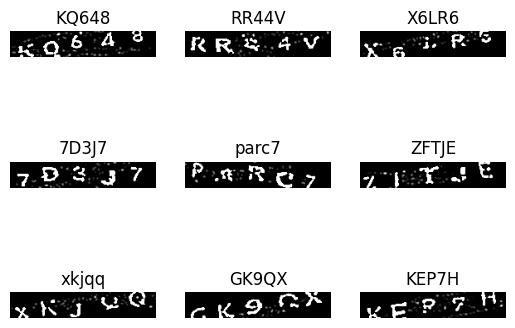

In [68]:
show_random_images(x_train, y_train)

In [69]:
# encode labels
y_train = np.array([encode_to_labels(y, char_list) for y in y_train])
print(y_train.shape)

(3136, 5)


In [70]:
# Trộn dữ liệu
combined_data = list(zip(x_train, y_train))
np.random.shuffle(combined_data)
x_train, y_train = zip(*combined_data)
x_train = np.array(x_train)
y_train = np.array(y_train)

# Convolutional Recurrent Neural Network (CRNN) Architecture

In [71]:
def create_crnn_model():
  inputs = Input(shape=(31, 176, 1))

  # convolution layer with kernel size (3,3)
  conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
  # poolig layer with kernel size (2,2)
  pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

  conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
  pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

  conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

  conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
  # poolig layer with kernel size (2,1)
  pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

  conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
  # Batch normalization layer
  batch_norm_5 = BatchNormalization()(conv_5)

  conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
  batch_norm_6 = BatchNormalization()(conv_6)
  pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

  conv_7 = Conv2D(512, (2, 2), activation='relu', padding='same')(pool_6)

  squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

  # Bidirectional LSTM layers
  blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(squeezed)
  blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(blstm_1)

  # Output layer
  outputs = Dense(len(char_list) + 1, activation='softmax') (blstm_2)

  # Model for testing
  act_model = Model(inputs, outputs)

  return act_model

In [80]:
crnn_model = create_crnn_model()
crnn_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 31, 176, 1)]      0         
                                                                 
 conv2d_42 (Conv2D)          (None, 31, 176, 64)       640       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 15, 88, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 15, 88, 128)       73856     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 7, 44, 128)        0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 7, 44, 256)        2951

## CTC loss

In [81]:
labels = Input(name='the_labels', shape=[5], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([crnn_model.output, labels, input_length, label_length])

# model to be used at training time
crnn_model = Model(inputs=[crnn_model.input, labels, input_length, label_length], outputs=loss_out)

In [82]:
crnn_model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'RMSprop')

In [83]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath="/content/drive/MyDrive/AI/Solve_Captcha_K+/best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

callbacks_list = [checkpoint]

In [84]:
batch_size = 32
epochs = 100
train_input_length = np.full(len(x_train), 44)
train_label_length = np.full(len(y_train), 5)
his = crnn_model.fit(x=[x_train, y_train, train_input_length, train_label_length], y=np.zeros(len(x_train)), batch_size=batch_size, epochs = epochs, validation_split=0.2, verbose = 1, callbacks = callbacks_list, shuffle=True)

Epoch 1/100
78/79 [============================>.] - ETA: 0s - loss: 22.2870
Epoch 1: val_loss improved from inf to 19.79514, saving model to /content/drive/MyDrive/AI/Solve_Captcha_K+/best_model.hdf5
79/79 [==============================] - 20s 96ms/step - loss: 22.2734 - val_loss: 19.7951
Epoch 2/100
78/79 [============================>.] - ETA: 0s - loss: 19.1671
Epoch 2: val_loss did not improve from 19.79514
79/79 [==============================] - 6s 81ms/step - loss: 19.1693 - val_loss: 21.1658
Epoch 3/100
78/79 [============================>.] - ETA: 0s - loss: 17.4473
Epoch 3: val_loss improved from 19.79514 to 18.11625, saving model to /content/drive/MyDrive/AI/Solve_Captcha_K+/best_model.hdf5
79/79 [==============================] - 5s 68ms/step - loss: 17.4387 - val_loss: 18.1162
Epoch 4/100
78/79 [============================>.] - ETA: 0s - loss: 13.9974
Epoch 4: val_loss improved from 18.11625 to 12.48734, saving model to /content/drive/MyDrive/AI/Solve_Captcha_K+/best_mo

KeyboardInterrupt: ignored

In [85]:
plt.plot(pre_train_his.history['val_loss'], c = 'coral', label = "validation loss line")
plt.plot(pre_train_his.history['loss'], c = 'blue', label = 'train loss line')
legend = plt.legend(loc='upper center')
plt.show()

NameError: ignored

# Predict

In [86]:
# load the saved best model weights
predict_model = create_crnn_model()
predict_model.load_weights("/content/drive/MyDrive/AI/Solve_Captcha_K+/best_model.hdf5")

# processing test data
test_data = np.array([pre_processing(image) for image in x_test])
print(test_data.shape)

# predict outputs on validation images
## predict one image
# image = x_test[0]
# prediction = predict_model.predict(np.expand_dims(image, axis=0))

## predict on test data
prediction = predict_model.predict(test_data)

# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])

# see the results
y_pred = []
for x in out:
  text = []
  for p in x:
    if int(p) != -1:
      text.append(p)
  y_pred.append(decode_from_labels(text, char_list))

(175, 31, 176, 1)
6/6 [==============================] - 2s 25ms/step


## Show result

In [87]:
accuracy = np.mean(y_test == np.array(y_pred)) * 100
print(accuracy)

62.857142857142854


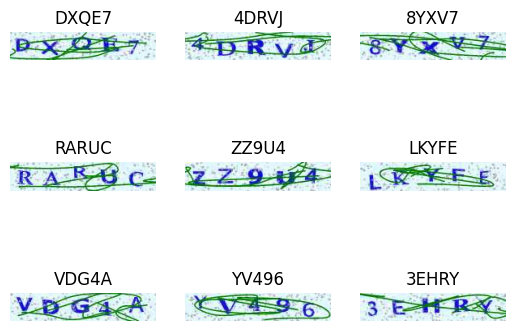

In [88]:
show_random_images(x_test, np.array(y_pred))